## Part C:  Deep Learning for Time Series Data

*Markdown formats: All tables and images will be aligned to the left.

In [3946]:
%%html
<style>table {float:left}</style>
<style>img {float:left}</style>

In [3947]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<hr style="height:1px;border:none;color:#333;background-color:#333;" />

**Task Description**

1. Construct a Recurrent Neural Network for multivariate time series prediction.
2. Run this notebook and record results.
3. Generate prediction and compare with the original timeseries. 

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

## Table of Content
   
1. [Notebook Preparation](#cell_Preparation)

2. [Data Preprocessing](#cell_Preprocessing)

3. [Model Construction](#cell_model)

4. [Model Execution](#cell_execution)
 
5. [Prediction](#cell_report)



<a id = "cell_Preparation"></a>
## 1. Notebook Preparation

*Load all required Python libraries (e.g. pandas, tensorflow, keras).*

In [3948]:
from __future__ import print_function
import os
import math
import datetime
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf
import time
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3949]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

In [3950]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, SGD, Adadelta
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from keras.layers import LeakyReLU
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import RandomUniform

In [3951]:
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.rcParams["figure.figsize"] = [10, 5]

***Allows display of data frames side by side.***

In [3952]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

***Store the model performance***

In [3953]:
# Initiates collections of model performance
def start_hist():
    return {}

# Adds more performance indicators to history
def collect_hist(accum_hist, next_hist):
    # Get all keys
    keys = list(next_hist.keys())
    for k in keys:
        if k in accum_hist:
            accum_hist[k].extend(next_hist[k])
        else:
            accum_hist[k] = next_hist[k]
    return accum_hist

***Define the function to plot the training history, i.e. the Mean Absolute Error and Loss (Mean Squared Error), which were both defined at the time of model compilation***

In [3954]:
def plot_hist(h, xsize=6, ysize=5):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    
    # Get training and validation keys
    ks = list(h.keys())
    n2 = math.floor(len(ks)/2)
    train_keys = ks[0:n2]
    valid_keys = ks[n2:2*n2]
    
    # summarize history for different metrics
    for i in range(n2):
        plt.plot(h[train_keys[i]])
        plt.plot(h[valid_keys[i]])
        plt.title('Training vs Validation '+train_keys[i])
        plt.ylabel(train_keys[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.draw()
        plt.show()
    
    return

<a id = "cell_Preprocessing"></a>
## 2. Data Preprocessing

*Load data from file and carry out necessary preprocessing.*

In [3955]:
# Load data
data_PartC = pd.read_csv('/content/drive/MyDrive/MIS780/A2/MIS780A2-DataSets/PartC-Stocks.csv') 
print('Stock data shape: ', data_PartC.shape) #print shape of data set
data_PartC.head(10) #print 10 first rows


Stock data shape:  (2516, 10)


,Date,Day,HPQ,GOOGL,MSFT,IBM,INTC,ADBE,AMZN,AAPL
0,1/4/10 12:00 AM,14612,23.819256,313.688690,30.950001,132.449997,20.879999,37.090000,133.899994,30.572857
1,1/5/10 12:00 AM,14613,23.919165,312.307312,30.959999,130.850006,20.870001,37.700001,134.690002,30.625713
2,1/6/10 12:00 AM,14614,23.696640,304.434448,30.770000,130.000000,20.799999,37.619999,132.250000,30.138571
3,1/7/10 12:00 AM,14615,23.705723,297.347351,30.450001,129.550003,20.600000,36.889999,130.000000,30.082857
4,1/8/10 12:00 AM,14616,23.882833,301.311310,30.660000,130.850006,20.830000,36.689999,133.520004,30.282858
5,1/11/10 12:00 AM,14619,23.810173,300.855865,30.270000,129.479996,20.950001,36.209999,130.309998,30.015715
6,1/12/10 12:00 AM,14620,23.601271,295.535522,30.070000,130.509995,20.610001,35.660000,127.349998,29.674286
7,1/13/10 12:00 AM,14621,23.714806,293.838837,30.350000,130.229996,20.959999,36.279999,129.110001,30.092857
8,1/14/10 12:00 AM,14622,23.846502,295.220215,30.959999,132.309998,21.480000,35.900002,127.349998,29.918571
9,1/15/10 12:00 AM,14623,23.828339,290.290283,30.860001,131.779999,20.799999,35.869999,127.139999,29.418571


In [3956]:
# Description of dataset
data_PartC.describe(include = 'all')

,Date,Day,HPQ,GOOGL,MSFT,IBM,INTC,ADBE,AMZN,AAPL
count,2516,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000
unique,2516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,3/6/17 12:00 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,16435.030604,16.078941,652.111853,56.322166,162.001892,32.489364,104.480763,676.207079,110.345293
std,NaN,1054.325591,4.776089,328.755875,33.863428,24.271917,10.704391,84.966762,580.440707,56.172958
min,NaN,14612.000000,5.317893,218.253250,23.010000,107.570000,17.670000,22.690001,108.610001,27.435715
25%,NaN,15521.250000,12.189729,317.869110,29.559999,143.037495,23.257500,34.274999,227.597496,64.714285
50%,NaN,16435.000000,15.887779,570.769989,44.400002,159.529999,30.860001,72.904999,375.140015,99.480000
75%,NaN,17346.750000,19.865320,947.542480,70.940002,184.007504,36.902501,143.597496,967.847488,150.552502


In [3957]:
# Identify null values
data_PartC.isnull().sum()

Date     0
Day      0
HPQ      0
GOOGL    0
MSFT     0
IBM      0
INTC     0
ADBE     0
AMZN     0
AAPL     0
dtype: int64

*Plot the time series data of some variables.*

**The figure of HHQ and AAPL**

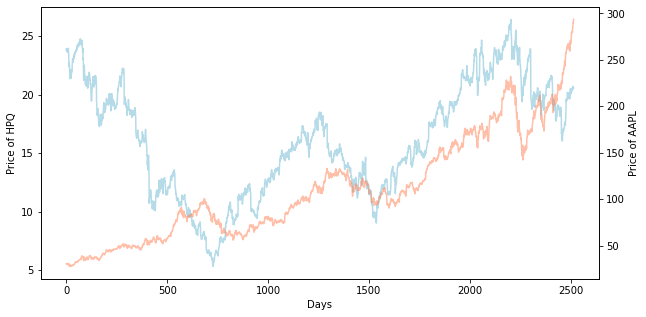

In [3958]:
ax1 = data_PartC['HPQ'].plot(color="lightblue", alpha=0.9)
ax1.set(xlabel='Days', ylabel='Price of HPQ')
ax2 = plt.twinx()
ax2.set(ylabel='Price of AAPL')
data_PartC['AAPL'].plot(color="coral", alpha=0.5, ax=ax2)

*Overall, the price of HHQ witnessed a slight decrease from 24 to 22 in the period of 2010 to 2019. To be more specific, there were two falls in the price of HHQ, from 25 to 5 (in 2012) and increase to 20 (in 2013) then decline to 10 (in 2014). This price peak at 27 (in 2016) and decreased to 22 at the end of the period.*

*Meanwhile, the price of AAPL dramatically surged from 10 to 300. More precisely, the value of AAPL witnessed 4 waves (2012, 2014, 2016 and 2019). It gradually increased to 120 and then decreased to 60 and then keep continuing to 225 before having a significant reduction to 140. After that, this price surged to 300 at the end of 2019.*

**The figure of GOOGL and AMZN**

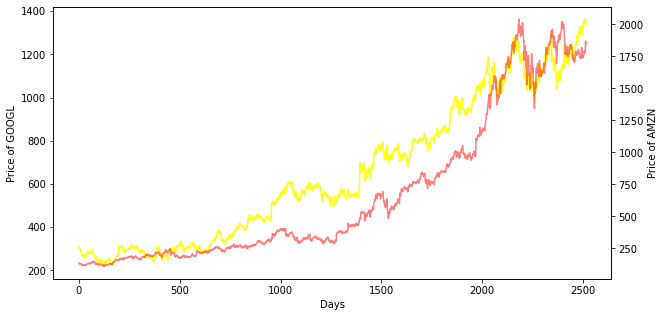

In [3959]:
ax1 = data_PartC['GOOGL'].plot(color="yellow", alpha=0.9)
ax1.set(xlabel='Days', ylabel='Price of GOOGL')
ax2 = plt.twinx()
ax2.set(ylabel='Price of AMZN')
data_PartC['AMZN'].plot(color="red", alpha=0.5, ax=ax2)

*It can be seen that, the price of GOOGL and AMZN witnessed an significant increase from 2010 to 2019. To be more specific, the value of GOOGL rise from 218 to 1360 while AMZN was 108 to 2039.*

*However, the price of GOOGL had two falls in 2016 and 2017, 1300 decrease to 1000 then increase to 1200 and decrease to 1100 again. Meanwhile, AMZN fell from 2000 to 1300.*

**The figure of MSFT and ADBE**

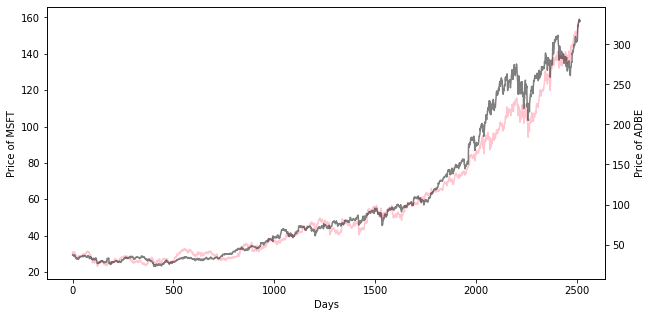

In [3960]:
ax1 = data_PartC['MSFT'].plot(color="pink", alpha=0.9)
ax1.set(xlabel='Days', ylabel='Price of MSFT')
ax2 = plt.twinx()
ax2.set(ylabel='Price of ADBE')
data_PartC['ADBE'].plot(color="black", alpha=0.5, ax=ax2)

*Similarly, the price of MSFT and ADBE also increase in the period of 2010 and 2019. Also, these stocks had the fall in the same year (2017) before rise again at the end of 2019.*

**The figure of IBM and INTC**

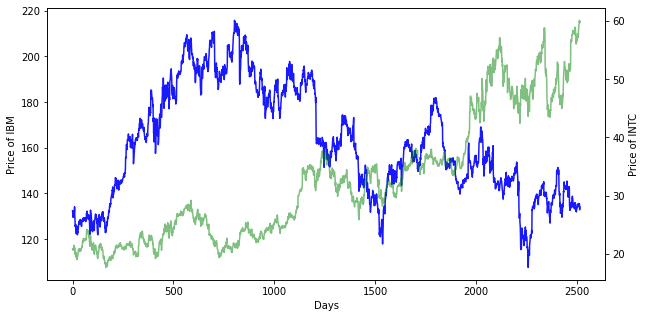

In [3961]:
ax1 = data_PartC['IBM'].plot(color="blue", alpha=0.9)
ax1.set(xlabel='Days', ylabel='Price of IBM')
ax2 = plt.twinx()
ax2.set(ylabel='Price of INTC')
data_PartC['INTC'].plot(color="green", alpha=0.5, ax=ax2)

*It can be seen that the price of IBM did not have difference in the period of 2010 and 2019. Although, this price surge from 130 to 210 (in 2012), it fell to 120 in 2014 and keep decreasing to 107 (in 2016). In 2019, it came back at the price same as 2010.*

*Meanwhile, INTC witnessed a dramatic change in this period. More precisely, it had a noisy movement, but it still surged from 20 to 60.*

**Since we dont have missing values so that data imputation is ignored**

In [3962]:
def data_resample(data_res):

    data_res = data_res.copy()
    
    # Create a sorted index from date
    data_res['Date'] = pd.to_datetime(data_res['Date'])
    data_res.index = data_res['Date']
    data_res.sort_index(inplace=True)
    del data_res['Date']

    # Upsample so the time-series has data for every day
    data_res = data_res.resample('D')

    # Fill in missing values by interpolating in between existing records
    data_res = data_res.interpolate(method='time')

    # Remove any empty rows that may have been created in this process
    data_res = data_res.dropna(how='all')
    
    # Location is no longer needed
    del data_res['Day']

    return data_res

In [3963]:
# Apply resample to data partC
data_PartC_RNN = data_resample(data_PartC)
data_PartC_RNN.head(10)

,HPQ,GOOGL,MSFT,IBM,INTC,ADBE,AMZN,AAPL
Date,,,,,,,,
2010-01-04,23.819256,313.688690,30.950001,132.449997,20.879999,37.090000,133.899994,30.572857
2010-01-05,23.919165,312.307312,30.959999,130.850006,20.870001,37.700001,134.690002,30.625713
2010-01-06,23.696640,304.434448,30.770000,130.000000,20.799999,37.619999,132.250000,30.138571
2010-01-07,23.705723,297.347351,30.450001,129.550003,20.600000,36.889999,130.000000,30.082857
2010-01-08,23.882833,301.311310,30.660000,130.850006,20.830000,36.689999,133.520004,30.282858
2010-01-09,23.858613,301.159495,30.530000,130.393336,20.870000,36.529999,132.450002,30.193810
2010-01-10,23.834393,301.007680,30.400000,129.936666,20.910000,36.369999,131.380000,30.104762
2010-01-11,23.810173,300.855865,30.270000,129.479996,20.950001,36.209999,130.309998,30.015715
2010-01-12,23.601271,295.535522,30.070000,130.509995,20.610001,35.660000,127.349998,29.674286


In [3964]:
# Observation the data type
data_PartC_RNN.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3649 entries, 2010-01-04 to 2019-12-31
Freq: D
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HPQ     3649 non-null   float64
 1   GOOGL   3649 non-null   float64
 2   MSFT    3649 non-null   float64
 3   IBM     3649 non-null   float64
 4   INTC    3649 non-null   float64
 5   ADBE    3649 non-null   float64
 6   AMZN    3649 non-null   float64
 7   AAPL    3649 non-null   float64
dtypes: float64(8)
memory usage: 256.6 KB


In [3965]:
# Identify null values
data_PartC_RNN.isnull().sum()

HPQ      0
GOOGL    0
MSFT     0
IBM      0
INTC     0
ADBE     0
AMZN     0
AAPL     0
dtype: int64

[Text(0, 0.5, 'Price'), Text(0.5, 0, 'Date')]

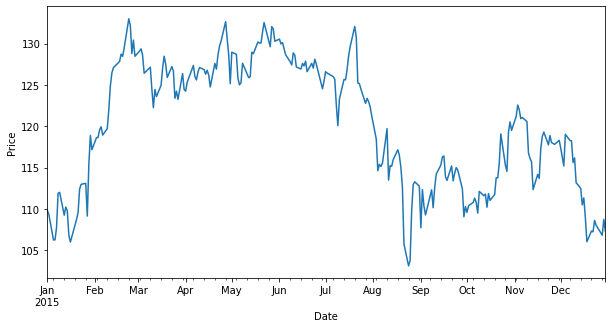

In [3966]:
#Plot the price of AAPL in the 2015
ax1 = data_PartC_RNN['AAPL']['2015-01-01':'2015-12-30'].plot()
ax1.set(xlabel='Date', ylabel='Price')

*The price was 110 in Jannuary, soared to 135 in March, then decrease to 102 at the end of August before come back to stating price at the end of 2015.*

*Split the data (e.g 0.7/0.3) and prepare the data for training and testing. Note that we will try to make prediction two days ahead (hint: shift the targeted variables two days backward to use as label). Clear indicates which variables are used as predictors in your code and explanation.*

In [3967]:
# Select target column
target_code = ['AAPL']
horizon = 2 # to shift the targeted variables two days backward to use as label

data_PartC_RNN_targets = data_PartC_RNN[target_code].shift(-horizon)
data_PartC_RNN_targets.head()

,AAPL
Date,
2010-01-04,30.138571
2010-01-05,30.082857
2010-01-06,30.282858
2010-01-07,30.193810
2010-01-08,30.104762


In [3968]:
# Show original examples and some for target column
org_df = pd.concat([data_PartC_RNN[target_code].head(horizon + 5)], keys=['Original Stock'], axis=1)
tg_df = pd.concat([data_PartC_RNN_targets.head(5)], keys=['Target Stock'], axis=1)
display_side_by_side(org_df, tg_df)

,Original Stock
,AAPL
Date,
2010-01-04,30.572857
2010-01-05,30.625713
2010-01-06,30.138571
2010-01-07,30.082857
2010-01-08,30.282858
2010-01-09,30.193810
2010-01-10,30.104762
,Target Stock


In [3969]:
# Correct predictors x and targets/labels y for the horizon shift
x_dataC = data_PartC_RNN.values[0:-horizon]
y_dataC = data_PartC_RNN_targets.values[:-horizon]

# # Splitting data 
# x_trainC, x_testC, y_trainC, y_testC = train_test_split(x_dataC, y_dataC, test_size = 0.3, random_state=2020, shuffle = False)

# # Identify time events to be used in training
# num_x_events = x_dataC.shape[1]
# num_y_events = y_dataC.shape[1]

# Calculate training and testing partition sizes
num_dataC = len(x_dataC)
train_split = 0.7
num_trainC = int(train_split * num_dataC)
num_testC = num_dataC - num_trainC

# Define boundaries for training and testing
x_trainC = x_dataC[0:num_trainC]
x_testC = x_dataC[num_trainC:]
y_trainC = y_dataC[0:num_trainC]
y_testC = y_dataC[num_trainC:]

# Identify time events to be used in training
num_x_eventsC = x_dataC.shape[1]
num_y_eventsC = y_dataC.shape[1]


print("Original x shape:", x_dataC.shape, ", New x shape:", x_trainC.shape, x_testC.shape)
print("Original y shape:", y_dataC.shape, ", New y shape:", y_trainC.shape, y_testC.shape)

Original x shape: (3647, 8) , New x shape: (2552, 8) (1095, 8)
Original y shape: (3647, 1) , New y shape: (2552, 1) (1095, 1)


*Change the dataset to the same scale ((from 0 to 1) based on MinMaxScaler*

In [3970]:
print("Before train x scaling - Min:", np.min(x_trainC), ", Max:", np.max(x_trainC))
print("Before test x scaling - Min:", np.min(x_testC), ", Max:", np.max(x_testC))
x_scalerC = MinMaxScaler(feature_range=(0, 1), copy=True)
x_train_scaledC = x_scalerC.fit_transform(x_trainC).clip(0, 1)
x_test_scaledC = x_scalerC.transform(x_testC).clip(0, 1)
print("After train x scaling - Min:", np.min(x_train_scaledC), ", Max:", np.max(x_train_scaledC))
print("After test x scaling - Min:", np.min(x_test_scaledC), ", Max:", np.max(x_test_scaledC))

Before train x scaling - Min: 5.317893028259277 , Max: 844.3599853515625
Before test x scaling - Min: 14.579999923706055 , Max: 2039.510009765625
After train x scaling - Min: 0.0 , Max: 1.0
After test x scaling - Min: 0.0 , Max: 1.0


In [3971]:
print("Before train y scaling - Min:", np.min(y_trainC), ", Max:", np.max(y_trainC))
print("Before test y scaling - Min:", np.min(y_testC), ", Max:", np.max(y_testC))

y_scalerC = x_scalerC
y_train_scaledC = y_scalerC.fit_transform(y_trainC)
y_test_scaledC = y_scalerC.transform(y_testC)
print("After train y scaling - Min:", np.min(y_train_scaledC), ", Max:", np.max(y_train_scaledC))
print("After test y scaling - Min:", np.min(y_test_scaledC), ", Max:", np.max(y_test_scaledC))

Before train y scaling - Min: 27.43571472167969 , Max: 133.0
Before test y scaling - Min: 115.98500061035156 , Max: 293.6499938964844
After train y scaling - Min: 0.0 , Max: 1.0
After test y scaling - Min: 0.8388185990670198 , Max: 2.521821451951582


*A generator function to create batches of shorter sub-sequences picked at random from training data*

In [3972]:
def batch_generator(batch_size, sequence_length):
    while True:
        # Allocate a new array for the batch of input-events.
        x_shapeC = (batch_size, sequence_length, num_x_eventsC)
        x_batchC = np.zeros(shape=x_shapeC, dtype=np.float16)

        # Allocate a new array for the batch of output-events.
        y_shapeC = (batch_size, sequence_length, num_y_eventsC)
        y_batchC = np.zeros(shape=y_shapeC, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_trainC - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batchC[i] = x_train_scaledC[idx:idx+sequence_length]
            y_batchC[i] = y_train_scaledC[idx:idx+sequence_length]
        
        yield (x_batchC, y_batchC)

*The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.*

In [3973]:
#Process 22 sequences before updating the model.
batch_size = 22 

#The length of each time series sequences/input dimenions.
sequence_length = 28 #7x4

In [3974]:
# Create the batch-generator
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [3975]:
# Test the batch-generator
x_batchC, y_batchC = next(generator)
print(x_batchC.shape)
print(y_batchC.shape)

(22, 28, 8)
(22, 28, 1)


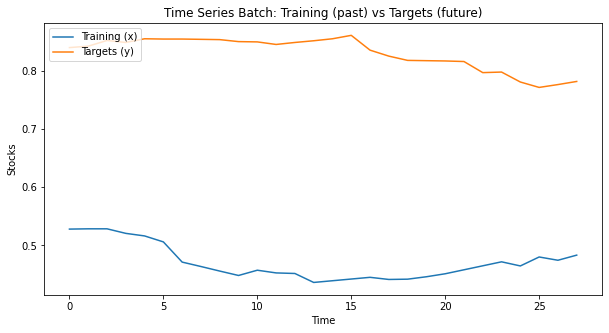

In [3976]:
# Plot one of the events
batchC = 0  # Some sequence in the batch
eventC = 0  # Some event from input-events
x_seqC = x_batchC[batchC, :, eventC]
y_seqC = y_batchC[batchC, :, eventC]
plt.plot(x_seqC)
plt.plot(y_seqC)
plt.title('Time Series Batch: Training (past) vs Targets (future)')
plt.ylabel('Stocks')
plt.xlabel('Time')
plt.legend(['Training (x)', 'Targets (y)'], loc='upper left')

In [3977]:
validation_data = (np.expand_dims(x_test_scaledC, axis=0),
                   np.expand_dims(y_test_scaledC, axis=0))

<a id = "cell_model"></a>
## 3. Model Construction

*Create one forecasting model using a Recurrent Neural Network, such as vanilla RNN, LSTM and GRU.*

*For all models, use mean_squared_error (MSE) as the loss function, and set the number of epochs to be 100, steps_per_epoch to be 60 and warmup_steps to be 7*

In [3978]:
# Create epochs, steps_per_epoch and warmup_steps
epochs = 100
steps_per_epoch = 60
warmup_steps = 7 # For custom loss function

In [3979]:
# The shape of both input tensors are: [batch_size, sequence_length, num_y_events]
def loss_mse_warmup(y_true, y_pred):
    # Ignore the "warmup" parts of the sequences
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]
    mse = mean(square(y_true_slice - y_pred_slice))   
    return mse

#### The GRU model initialize weights with smaller values to avoid `NaN` values during training because we use more layers.

In [3980]:
# Create model
def rnn_model_gru(num_x_eventsC, num_y_eventsC):
    init = RandomUniform(minval=-0.05, maxval=0.05)
    model = Sequential()
    model.add(GRU(units=1024, 
              return_sequences=True,
              kernel_initializer='normal',
              kernel_regularizer=regularizers.l1(0.01), 
              bias_regularizer=regularizers.l1(0.01),              
              input_shape=(None, num_x_eventsC,)))
    model.add(LeakyReLU(alpha=0.002))
    model.add(Dropout(0.2))
    model.add(BatchNormalization(momentum=0.01))

    model.add(Dense(512,
              kernel_initializer='normal',
              kernel_regularizer=regularizers.l1_l2(0.01), 
              bias_regularizer=regularizers.l1_l2(0.01)))
    model.add(LeakyReLU(alpha=0.002))
    model.add(Dropout(0.1))
    model.add(BatchNormalization(momentum=0.01))
    model.add(Dropout(0.0))

    model.add(Dense(num_y_eventsC, activation='linear',
                    kernel_initializer=init))
    model.summary()
    return(model)

**The first layer is GRU with 1024 units, use regularizers.l1 = 0.01 and input dimension is 8 features.** 

**The second layer is LeakyRelu with alpha = 0.002
Use the first drop out with 20% in third layer.
Then use BatchNormalization layer with momentum=0.01.**

**In next Dense layer, use 512 nodes with regularizers.l1_l2 = 0.01
Then apply 10% dropout before using BatchNormalization layer with momentum=0.01 again.**

**Finally, 0% dropout applied before using last layer with 1 output for 2 day step and activation is linear.**

*Save checkpoints and log the progress to TensorBoard for call back later*

In [3981]:
path_checkpoint = './gru_checkpoints/'

callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
        monitor='val_loss',
        verbose=1,
        save_weights_only=True,
        save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss',
        patience=10, verbose=1)

callback_tensorboard = TensorBoard(log_dir='./gru_logs/',
        histogram_freq=0,
        write_graph=False)

# This callback reduces the learning-rate if the validation-loss has not improved as defined by `patience`.
# The learning-rate will be reduced by a `factor` (by multiplying) but no more than `min_lr`.
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
        factor=0.3,
        min_lr=1e-4,
        patience=5,
        min_delta = 1e-3,
        verbose=1)

keras_callbacks = [
        callback_early_stopping,
        callback_reduce_lr,
        callback_checkpoint
]

In [3982]:
# Define a  optimizers 
opt_adam_1 = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

# Start collecting history, in case we train the model iteratively
rnn_hist_partC = start_hist()

model_partC = rnn_model_gru(num_x_eventsC, num_y_eventsC)
model_partC.compile(loss=loss_mse_warmup, optimizer=opt_adam_1, metrics=[metrics.mae])

Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_141 (GRU)                (None, None, 1024)        3176448   
_________________________________________________________________
leaky_re_lu_128 (LeakyReLU)  (None, None, 1024)        0         
_________________________________________________________________
dropout_154 (Dropout)        (None, None, 1024)        0         
_________________________________________________________________
batch_normalization_130 (Bat (None, None, 1024)        4096      
_________________________________________________________________
dense_104 (Dense)            (None, None, 512)         524800    
_________________________________________________________________
leaky_re_lu_129 (LeakyReLU)  (None, None, 512)         0         
_________________________________________________________________
dropout_155 (Dropout)        (None, None, 512)       

**The model need 3,707,905 params to buil model and use Adam optimizer for this model.**

<a id = "cell_execution"></a>
## 4. Model Execution

*This section is to provide code to fit the models. Record and plot the history of training and validation. Report the performance (mean_absolute_error and loss) of the trained model on the both the training and the test sets.*<br>

In [3983]:
# Fit model
%%time
perform_indics = model_partC.fit(x=generator,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_data,
        callbacks=keras_callbacks,
        verbose=2
        )

# Add performance history
rnn_hist_partC = collect_hist(rnn_hist_partC, perform_indics.history)

Epoch 1/100
60/60 - 3s - loss: 126.3454 - mean_absolute_error: 0.5988 - val_loss: 48.5840 - val_mean_absolute_error: 0.5799

Epoch 00001: val_loss improved from inf to 48.58405, saving model to ./gru_checkpoints/
Epoch 2/100
60/60 - 1s - loss: 21.0063 - mean_absolute_error: 0.4750 - val_loss: 6.5032 - val_mean_absolute_error: 0.6237

Epoch 00002: val_loss improved from 48.58405 to 6.50315, saving model to ./gru_checkpoints/
Epoch 3/100
60/60 - 1s - loss: 2.9645 - mean_absolute_error: 0.4855 - val_loss: 2.1952 - val_mean_absolute_error: 0.8841

Epoch 00003: val_loss improved from 6.50315 to 2.19519, saving model to ./gru_checkpoints/
Epoch 4/100
60/60 - 1s - loss: 0.9968 - mean_absolute_error: 0.3709 - val_loss: 1.1458 - val_mean_absolute_error: 0.5143

Epoch 00004: val_loss improved from 2.19519 to 1.14584, saving model to ./gru_checkpoints/
Epoch 5/100
60/60 - 1s - loss: 0.7394 - mean_absolute_error: 0.2319 - val_loss: 1.0474 - val_mean_absolute_error: 0.5212

Epoch 00005: val_loss im

**The final mae validaton is 46 with Wall time is 52s**

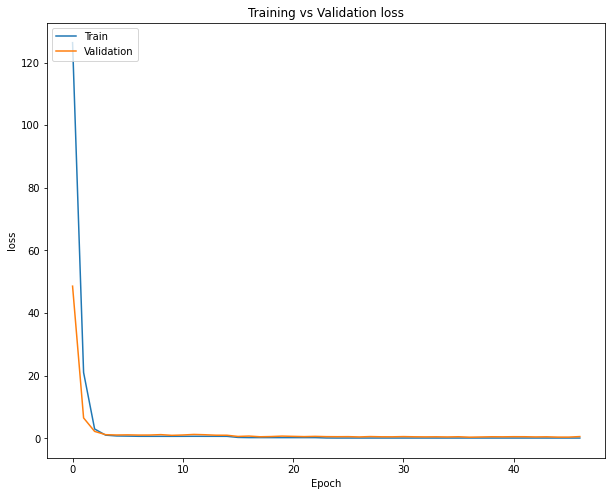

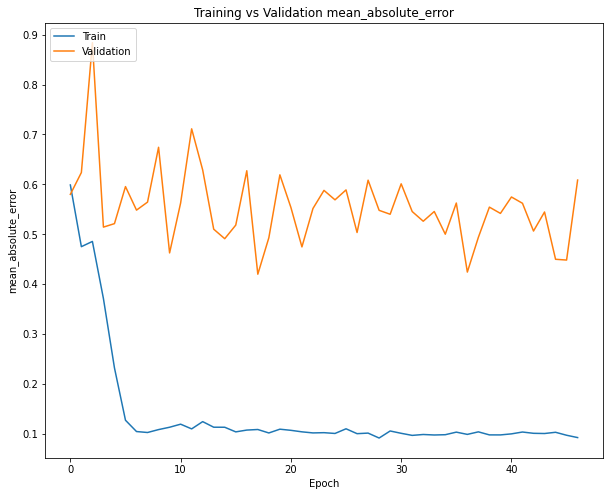

In [3984]:
# Plot the model performance
plot_hist(rnn_hist_partC, xsize=10, ysize=8)

***The figure of training vs validation loss shows that this is a good fit. However, training and validation mae reflects that the model is overfitting when mae validation is consistanly higher than mae training. This is normal when using deep learning for prediction***

*Used ModelCheckpoint callback to reload the last saved checkpoint, which had the best performance on the validation set.*

In [3985]:
try:
    model_partC.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

*Observe training performance based on MAE and loss*

In [3986]:
result = model_partC.evaluate(x=np.expand_dims(x_train_scaledC, axis=0),
                        y=np.expand_dims(y_train_scaledC, axis=0))
# We have several metrics so we want to show their names
print()
for res, metric in zip(result, model_partC.metrics_names):
    print("{0}: {1:.5f}".format(metric, res))

1/1 [==============================] - 1s 670ms/step - loss: 0.0752 - mean_absolute_error: 0.0290

loss: 0.07524
mean_absolute_error: 0.02897


*Observe testing performance based on MAE and loss*

In [3987]:
result = model_partC.evaluate(x=np.expand_dims(x_test_scaledC, axis=0),
                        y=np.expand_dims(y_test_scaledC, axis=0))
# We have several metrics so we want to show their names
print()
for res, metric in zip(result, model_partC.metrics_names):
    print("{0}: {1:.5f}".format(metric, res))

1/1 [==============================] - 0s 127ms/step - loss: 0.3531 - mean_absolute_error: 0.4241

loss: 0.35310
mean_absolute_error: 0.42407


<a id = "cell_report"></a>
## 5. Prediction

*Generate prediction: the predicted and true output time series of the targeted variable.*

In [3988]:
# Plot the predicted and true output-events.

def plot_comparison(start_idx, length=100, trainC=True, xlim=None, ylim=None):
    """
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if trainC:
        # Use training-data.
        x = x_train_scaledC
        y_true = y_trainC
    else:
        # Use test-data.
        x = x_test_scaledC
        y_true = y_testC
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-events for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-events.
    y_pred = model_partC.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scalerC.inverse_transform(y_pred[0])
    
    # For each output-event.
    for event in range(len(target_code)):
        # Get the output-event predicted by the model.
        event_pred = y_pred_rescaled[:, event]
        
        # Get the true output-event from the data-set.
        event_true = y_true[:, event]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two events.
        plt.plot(event_true, label='true price')
        plt.plot(event_pred, label='pred price')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        if (xlim): plt.xlim(xlim)
        if (ylim): plt.ylim(ylim)
        plt.ylabel(target_code[event])
        plt.legend()
        plt.show()

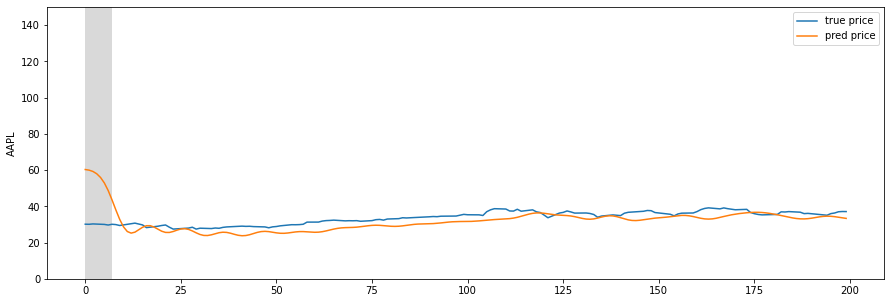

In [3989]:
# Plot the traning data
plot_comparison(start_idx=0, length=200, trainC=True, ylim=(0,150))

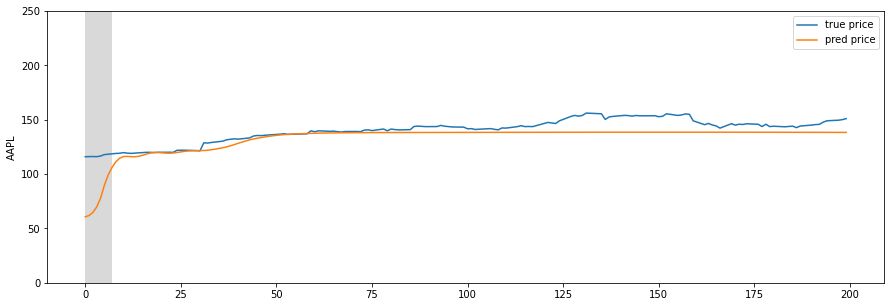

In [3990]:
# Plot the testing data
plot_comparison(start_idx=0, length=200, trainC=False, ylim=(0,250))


**It can be seen that the model predict very well in both dataset. To be more specific, the pattern of predicted values is very stable and it does not have a gap in two types of value.**

*Summary of experimental results in the table below.*

| Dataset# |  Loss | MAE | 
| :-: | -: | -: |
| Training | 0.07524  | 0.02897| 
| Testing | 0.35310  |0.42407| 


**Overall, the model used eight stocks from 2010 to 2019 to predict the price of one stock in next days. The model shows the good performance when the MAE and Loss are low. Also, the graphs proved it as well. Hence, The model can be used in reality to predict the stocks.**